In [28]:
%matplotlib widget

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets

from sklearn.metrics import accuracy_score, log_loss
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import ConstantKernel, DotProduct
from sklearn.gaussian_process.kernels import Matern

# Introduction

Gaussian Processes (GP) are a generic supervised learning method designed to solve both regression and probabilistic classification problems. It is a way of modelling a problem where every linear combination of variables has a normal (ie. Gaussian) distribution. Given prior knowledge of the problem at hand, one can provide an appropriate distribution kernel which helps the model both converge faster and quantify its output. A Gaussian process uses this "kernel trick" to define the covariance of the supplied prior distribution over a target function and uses the observed data to a define a likelihood function. The model then is able to provide meaningful confidence intervals and posterior samples along with its predictions.

The advantages of Gaussian processes are:

- The prediction interpolates the observations (at least for regular kernels).

- The prediction is probabilistic (Gaussian) so that one can compute empirical confidence intervals and decide based on those if one should refit (online fitting, adaptive fitting) the prediction in some region of interest.

- Versatile: different kernels can be specified. Common kernels are provided, but it is also possible to specify custom kernels.

The disadvantages of Gaussian processes include:

- They are not sparse, i.e., they use the whole samples/features information to perform the prediction.

- They are not good in high dimensional spaces – namely when the number of features exceeds a few dozens.

# Kernels

Let us first visualize the different available kernels by plotting samples drawn from the prior distribution and then the posterior distribution after training.

In [14]:
# helper function to draw prior and posterior distributions

def plot_gpr_samples(gpr_model, n_samples, ax):
    x = np.linspace(0, 5, 100)
    X = x.reshape(-1, 1)

    y_mean, y_std = gpr_model.predict(X, return_std=True)
    y_samples = gpr_model.sample_y(X, n_samples)

    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", label="Mean")
    ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_ylim([-3, 3])

In [7]:
# Generate data

rng = np.random.RandomState(4)
X_train = rng.uniform(0, 5, 10).reshape(-1, 1)
y_train = np.sin((X_train[:, 0] - 2.5) ** 2)
n_samples = 5

# RBF

A.K.A. the Radial Basis Function kernel, the Gaussian kernel. It has the form:

This kernel should be called the "Exponentiated Quadratic". This kernel has become the de-facto default kernel for GPs and SVMs. This is probably because it has some nice properties. It is universal, and you can integrate it against most functions that you need to. Every function in its prior has infinitely many derivatives. It also has only two parameters:
- The lengthscale determines the length of the 'wiggles' in your function. In general, you won't be able to extrapolate more than units away from your data.
- The output variance determines the average distance of your function away from its mean. Every kernel has this parameter out in front; it's just a scale factor.


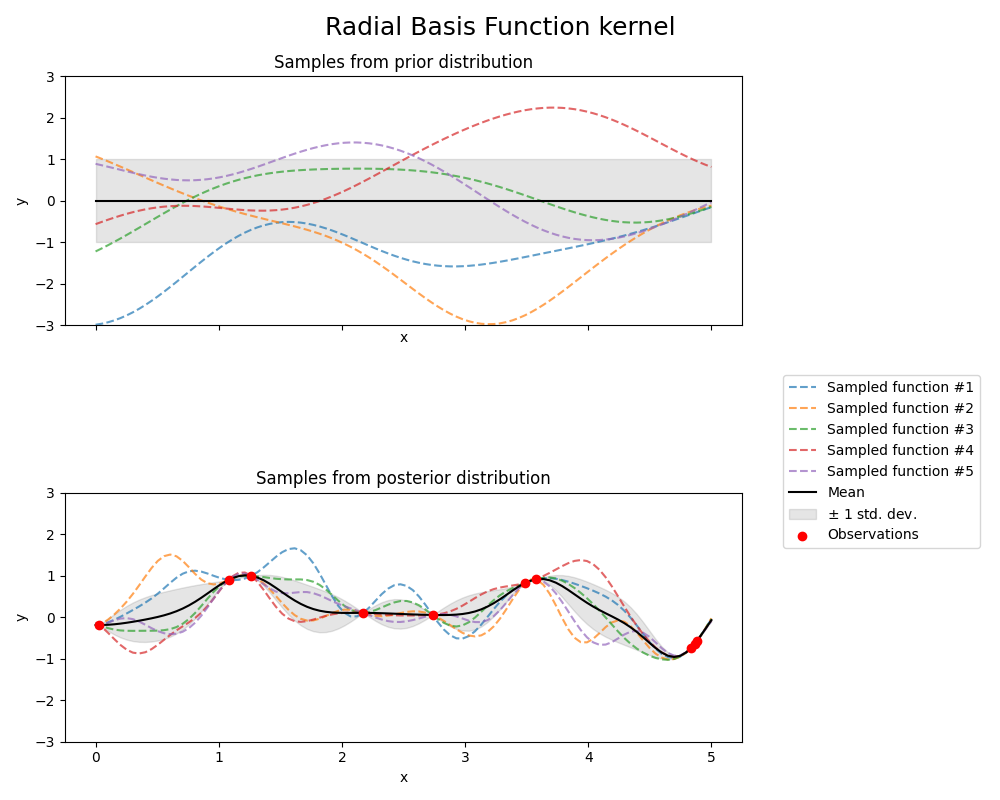

In [10]:
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)

fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(10, 8))

# plot prior
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[0])
axs[0].set_title("Samples from prior distribution")

# plot posterior
gpr.fit(X_train, y_train)
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[1])
axs[1].scatter(X_train[:, 0], y_train, color="red", zorder=10, label="Observations")
axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")

fig.suptitle("Radial Basis Function kernel", fontsize=18)
plt.tight_layout()

# Rational Quadratic

This kernel is equivalent to adding together many SE kernels with different lengthscales. So, GP priors with this kernel expect to see functions which vary smoothly across many lengthscales. The parameter determines the relative weighting of large-scale and small-scale variations. When , the RQ is identical to the SE.

Pitfalls of the SE and RQ kernels

Most people who set up a GP regression or classification model end up using the Squared-Exp or Rational Quadratic kernels. They are a quick-and-dirty solution that will probably work pretty well for interpolating smooth functions when N is a multiple of D, and when there are no 'kinks' in your function. If your function happens to have a discontinuity or is discontinuous in its first few derivatives (for example, the abs() function), then either your lengthscale will end up being extremely short, and your posterior mean will become zero almost everywhere, or your posterior mean will have 'ringing' effects. Even if there are no hard discontinuities, the lengthscale will usually end up being determined by the smallest 'wiggle' in your function - so you might end up failing to extrapolate in smooth regions if there is even a small non-smooth region in your data.

If your data is more than two-dimensional, it may be hard to detect this problem. One indication is if the lengthscale chosen by maximum marginal likelihood never stops becoming smaller as you add more data. This is a classic sign of model misspecification.

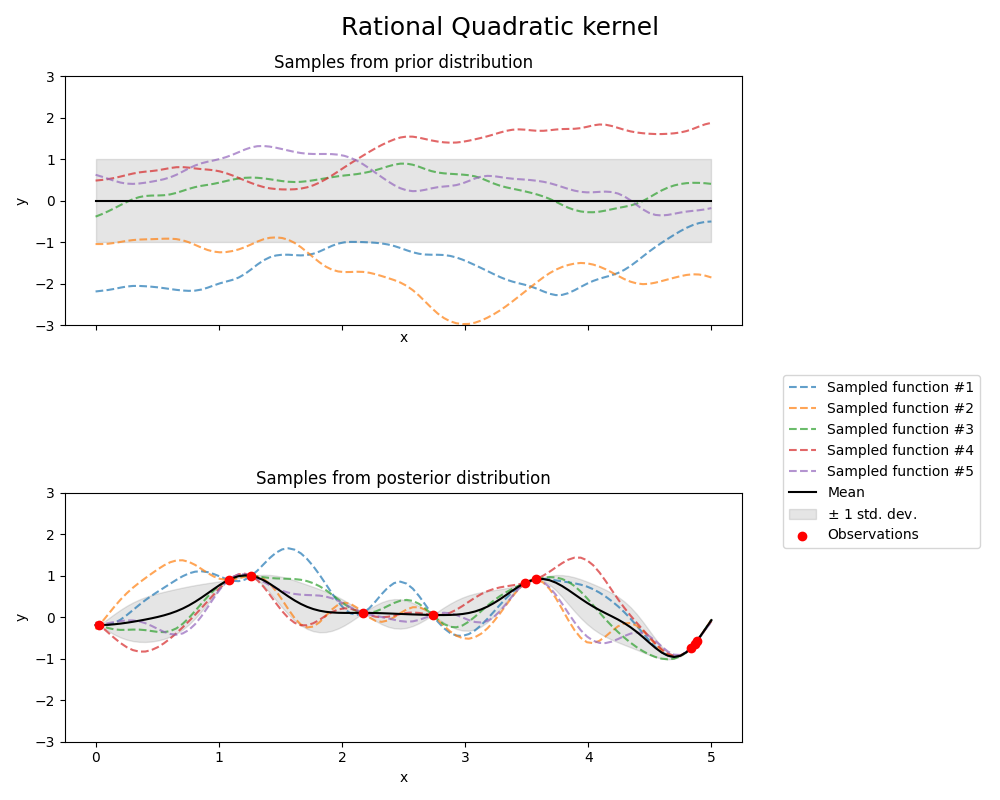

In [13]:
kernel = 1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1, alpha_bounds=(1e-5, 1e15))
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)

fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(10, 8))

# plot prior
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[0])
axs[0].set_title("Samples from prior distribution")

# plot posterior
gpr.fit(X_train, y_train)
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[1])
axs[1].scatter(X_train[:, 0], y_train, color="red", zorder=10, label="Observations")
axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")

fig.suptitle("Rational Quadratic kernel", fontsize=18)
plt.tight_layout()

# Periodic

The periodic kernel (derived by David Mackay) allows one to model functions which repeat themselves exactly. Its parameters are easily interpretable:
    
- The period simply determines the distnace between repititions of the function.
- The lengthscale determines the lengthscale function in the same way as in the SE kernel.


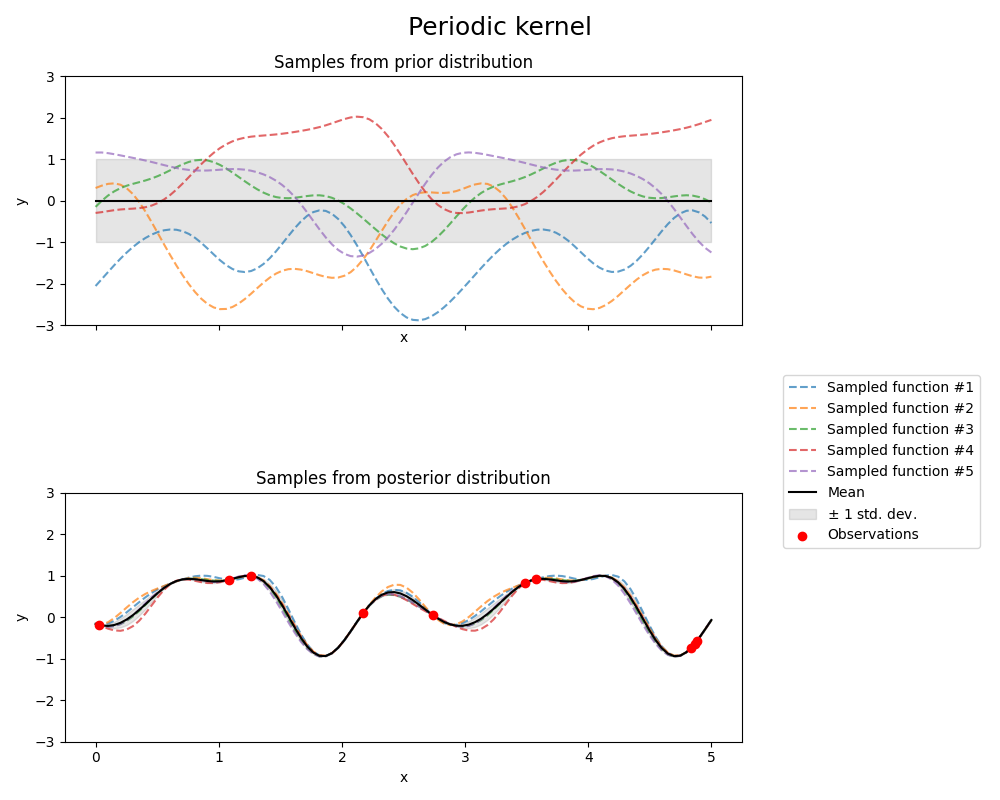

In [17]:
kernel = 1.0 * ExpSineSquared(
    length_scale=1.0,
    periodicity=3.0,
    length_scale_bounds=(0.1, 10.0),
    periodicity_bounds=(1.0, 10.0),
)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)

fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(10, 8))

# plot prior
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[0])
axs[0].set_title("Samples from prior distribution")

# plot posterior
gpr.fit(X_train, y_train)
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[1])
axs[1].scatter(X_train[:, 0], y_train, color="red", zorder=10, label="Observations")
axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")

fig.suptitle("Periodic kernel", fontsize=18)
plt.tight_layout()

# Dot product
Multiplying together kernels is the standard way to combine two kernels, especially if they are defined on different inputs to your function.

Roughly speaking, multiplying two kernels can be thought of as an AND operation. That is, if you multiply together two kernels, then the resulting kernel will have high value only if both of the two base kernels have a high value. 

A linear kernel times another linear kernel results in functions which are quadratic! This trick can be taken to produce Bayesian polynomial regression of any degree.

In scikit learn, we have a polynomial kernel which grows rapidly with |x| for |x| > 1. Such kernels have proved effective in high-dimensional classification problems (e.g. take x to be a vectorized binary image) where the input data are binary or greyscale normalized to [−1, 1] on each dimension.

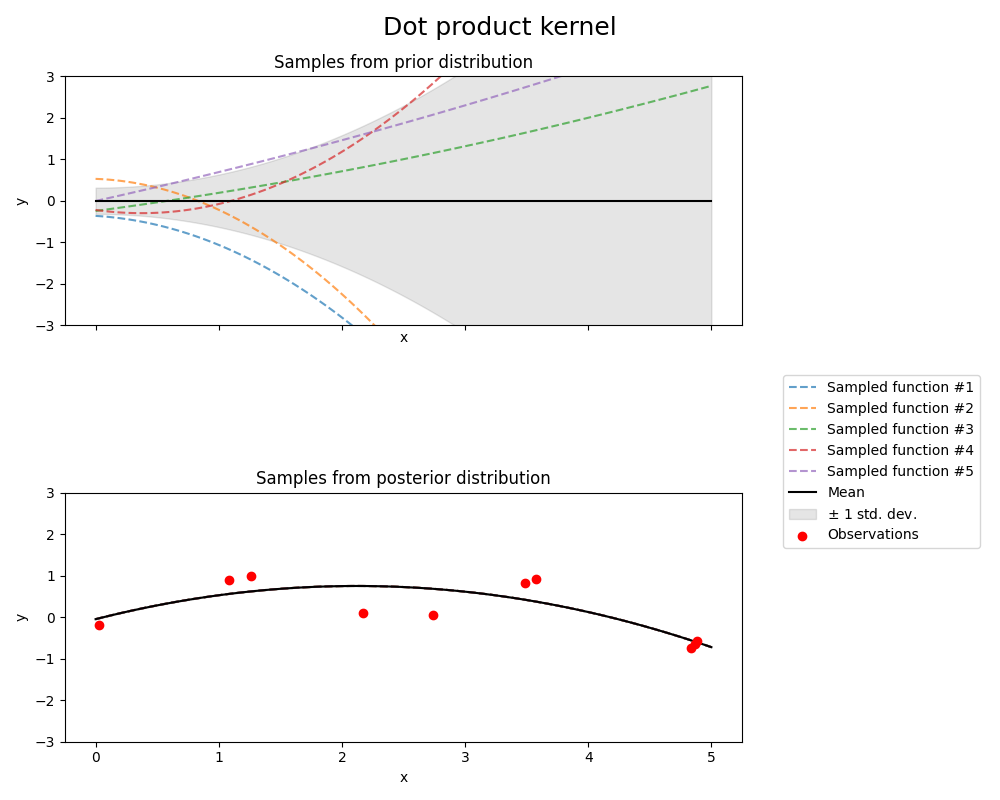

In [20]:
kernel = ConstantKernel(0.1, (0.01, 10.0)) * (
    DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 30.0)) ** 2
)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)

fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(10, 8))

# plot prior
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[0])
axs[0].set_title("Samples from prior distribution")

# plot posterior
gpr.fit(X_train, y_train)
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[1])
axs[1].scatter(X_train[:, 0], y_train, color="red", zorder=10, label="Observations")
axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")

fig.suptitle("Dot product kernel", fontsize=18)
plt.tight_layout()

# Matten

The Matern kernel is a stationary kernel and a generalization of the RBF kernel. It has an additional parameter `v` which controls the smoothness of the resulting function. It is parameterized by a length-scale parameter `l > 0`, which can either be a scalar (isotropic variant of the kernel) or a vector with the same number of dimensions as the inputs (anisotropic variant of the kernel). 

The flexibility of controlling the smoothness of the learned function via `v` allows adapting to the properties of the true underlying functional relation.

In [ ]:
kernel = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)

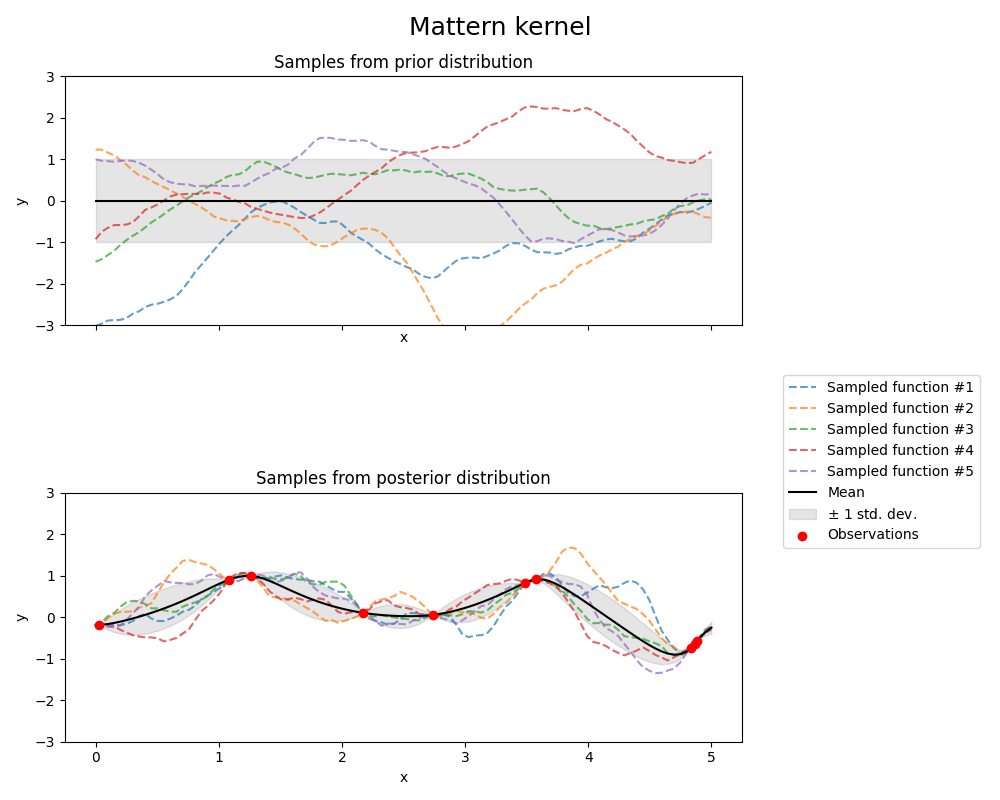

In [21]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(10, 8))

# plot prior
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[0])
axs[0].set_title("Samples from prior distribution")

# plot posterior
gpr.fit(X_train, y_train)
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[1])
axs[1].scatter(X_train[:, 0], y_train, color="red", zorder=10, label="Observations")
axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")

fig.suptitle("Mattern kernel", fontsize=18)
plt.tight_layout()

# Classification

In [22]:
# Generate data
train_size = 50
rng = np.random.RandomState(0)
X = rng.uniform(0, 5, 100)[:, np.newaxis]
y = np.array(X[:, 0] > 2.5, dtype=int)

This example illustrates the predicted probability of GPC for an RBF kernel with different choices of the hyperparameters. The first figure shows the predicted probability of GPC with arbitrarily chosen hyperparameters and with the hyperparameters corresponding to the maximum log-marginal-likelihood (LML).

While the hyperparameters chosen by optimizing LML have a considerable larger LML, they perform slightly worse according to the log-loss on test data. The figure shows that this is because they exhibit a steep change of the class probabilities at the class boundaries (which is good) but have predicted probabilities close to 0.5 far away from the class boundaries (which is bad) This undesirable effect is caused by the Laplace approximation used internally by GPC.

The second figure shows the log-marginal-likelihood for different choices of the kernel’s hyperparameters, highlighting the two choices of the hyperparameters used in the first figure by black dots.

In [24]:
# Let us specify two Gaussian Processes using RBF kernels
# the first one has with fixed parameters
# the second one has (manualyl) optimized hyperparameters

gp_fix = GaussianProcessClassifier(kernel=1.0 * RBF(length_scale=1.0), optimizer=None)
gp_fix.fit(X[:train_size], y[:train_size])

gp_opt = GaussianProcessClassifier(kernel=1.0 * RBF(length_scale=1.0))
gp_opt.fit(X[:train_size], y[:train_size])

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))

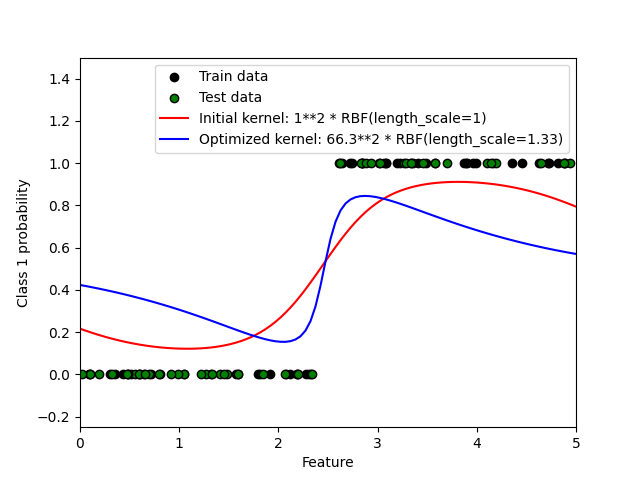

In [27]:
plt.figure()
plt.scatter(
    X[:train_size, 0], y[:train_size], c="k", label="Train data", edgecolors=(0, 0, 0)
)
plt.scatter(
    X[train_size:, 0], y[train_size:], c="g", label="Test data", edgecolors=(0, 0, 0)
)
X_ = np.linspace(0, 5, 100)
plt.plot(
    X_,
    gp_fix.predict_proba(X_[:, np.newaxis])[:, 1],
    "r",
    label="Initial kernel: %s" % gp_fix.kernel_,
)
plt.plot(
    X_,
    gp_opt.predict_proba(X_[:, np.newaxis])[:, 1],
    "b",
    label="Optimized kernel: %s" % gp_opt.kernel_,
)
plt.xlabel("Feature")
plt.ylabel("Class 1 probability")
plt.xlim(0, 5)
plt.ylim(-0.25, 1.5)
plt.legend(loc="best")

In [38]:
# let us try the same task on a familiar dataset

iris = datasets.load_iris()
X = iris.data[:, :2]
y = np.array(iris.target, dtype=int)

In [39]:
# we will focus on the RBF kernel, and see the difference between
# having an isotropic and anisotropic kernel

# anisotropy in general means that a distance function is not uniform in every direction

h = 0.02  # step size in the mesh

kernel = 1.0 * RBF([1.0])
gpc_rbf_isotropic = GaussianProcessClassifier(kernel=kernel).fit(X, y)

kernel = 1.0 * RBF([1.0, 1.0])
gpc_rbf_anisotropic = GaussianProcessClassifier(kernel=kernel).fit(X, y)

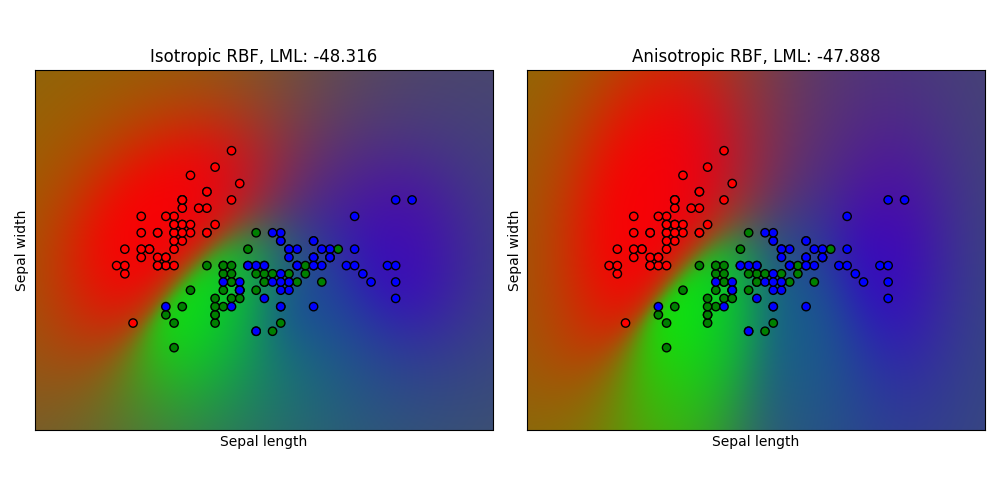

In [40]:
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

titles = ["Isotropic RBF", "Anisotropic RBF"]
plt.figure(figsize=(10, 5))
for i, clf in enumerate((gpc_rbf_isotropic, gpc_rbf_anisotropic)):
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(1, 2, i + 1)

    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape((xx.shape[0], xx.shape[1], 3))
    plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=np.array(["r", "g", "b"])[y], edgecolors=(0, 0, 0))
    plt.xlabel("Sepal length")
    plt.ylabel("Sepal width")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(
        "%s, LML: %.3f" % (titles[i], clf.log_marginal_likelihood(clf.kernel_.theta))
    )

plt.tight_layout()
plt.show()

# we see the subtle effect of an anisotropic kernel is that it is able to produce tighter boundaries

# Regression & Confidence

In [52]:
# let us generate some data where we know the underlying generative process

X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

# let us pick out just a few points for training

training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

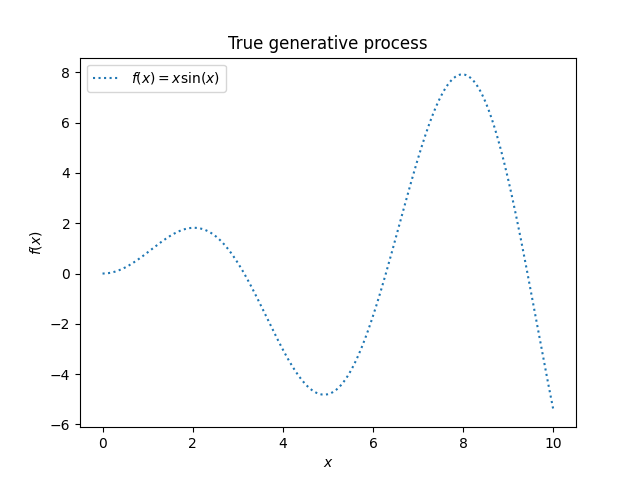

In [53]:
# clear old visualizations
plt.close('all')

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

In [54]:
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)

mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

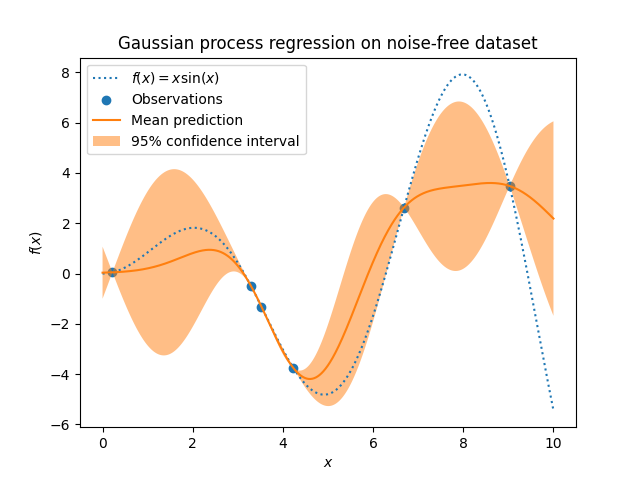

In [55]:
# clear old visualizations
plt.close('all')

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

In [101]:
# lets try that again with a few more points

training_indices = rng.choice(np.arange(y.size), size=15, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

In [102]:
# here we switch to a Matern kernel for easy convergence

kernel = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)

mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

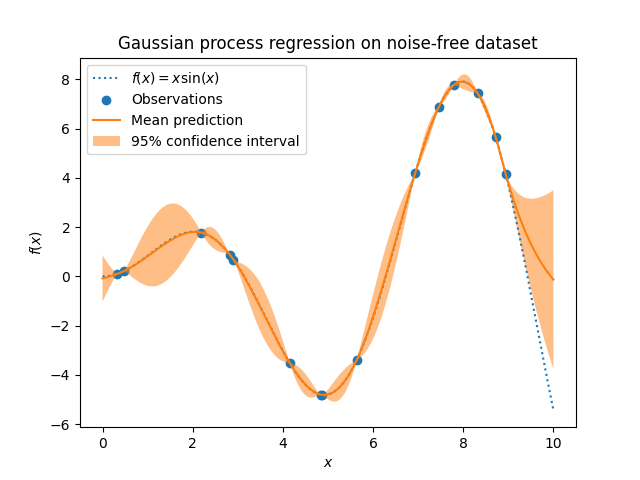

In [103]:
# clear old visualizations
plt.close('all')

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

# Noise

In [129]:
training_indices = rng.choice(np.arange(y.size), size=10, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

noise_std = 0.75
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

In [130]:
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, alpha=noise_std ** 2, n_restarts_optimizer=9
)
gaussian_process.fit(X_train, y_train_noisy)
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

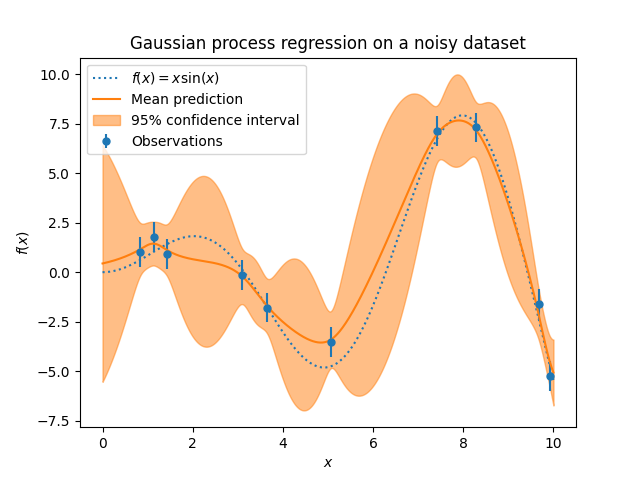

In [131]:
# clear old visualizations
plt.close('all')

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset")